In [3]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.visualization import perf_tester

import numpy as np
import bayesflow as bf
import tensorflow as tf
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Load network

In [5]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_1']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_1']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_1']['dense_equiv_args']), 
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_2']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_2']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_2']['dense_equiv_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                   dense_args=probability_meta_validation['dense_args'], 
                                                   dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [6]:
# Training steps
epochs = 40 
iterations_per_epoch = 1000

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    default_lr=0.00025,
    checkpoint_path=checkpoint_path
    )

# Sample size
n_clusters = 25
n_obs = 50

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\history_40.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\ckpt-40


# Get OOD score

## Utility functions

In [7]:
def noise_simulator(batch_size, n_clusters=25, n_obs=50, RNG=None, **kwargs):
    """ Generates a single hierarchical data set. """
    if RNG is None:
        RNG = np.random.default_rng()
    data = RNG.integers(low=0, high=2, size=(batch_size, n_clusters, n_obs, 2)) 
    #data = RNG.integers(low=-100, high=101, size=(batch_size, n_clusters, n_obs, 2))

    out_dict = {
        DEFAULT_KEYS["sim_data"]: data,
    }

    return out_dict

In [8]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
mpt_simulator = partial(sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)

In [9]:
def get_max_activation(data, probability_net, summary_net, method):
    """ Gets the inference networks' last-layer-activation, either before or after 
    passing it through the softmax function. """

    if method=='max_softmax':
        activations = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(data, 20)])
    if method=='max_logits':
        activations = np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(data, 20)])
          
    max_activation = np.max(activations, axis=1)

    return max_activation

## Data generation

In [10]:
num_data_sets = 5000

sdt_data = sdt_simulator(num_data_sets)['sim_data']
mpt_data = mpt_simulator(num_data_sets)['sim_data']
noise_data = noise_simulator(num_data_sets)['sim_data']

## max_softmax

In [11]:
sdt_max_softmax = get_max_activation(sdt_data, probability_net, summary_net, 'max_softmax')
mpt_max_softmax = get_max_activation(mpt_data, probability_net, summary_net, 'max_softmax')
noise_max_softmax = get_max_activation(noise_data, probability_net, summary_net, 'max_softmax')
print(np.mean(sdt_max_softmax), np.mean(mpt_max_softmax), np.mean(noise_max_softmax))

0.9399715 0.9296052 0.9927288


In [12]:
def get_percentage_rejected(model_activations, noise_activations, ci=[0.025, 0.975]):

    proportions_rejected = []

    for activations in model_activations:
        lower_threshold, upper_threshold = np.quantile(activations, q=ci, axis=0)
        print(lower_threshold, upper_threshold)
        print(np.max(noise_activations))
        rejected = np.logical_or(noise_activations < lower_threshold, noise_activations > upper_threshold)
        proportion_rejected = np.sum(rejected) / len(noise_activations)
        proportions_rejected.append(proportion_rejected)

    return proportions_rejected

get_percentage_rejected([sdt_max_softmax, mpt_max_softmax], noise_max_softmax)

0.5715583711862564 0.9963496118783951
0.99648833
0.5866385504603386 0.9968472719192505
0.99648833


[0.0014, 0.0]

Text(0.5, 1.0, 'MaxSoftmax')

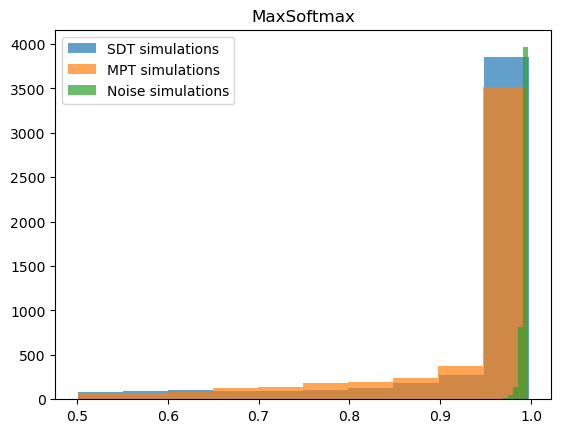

In [13]:
plt.hist(sdt_max_softmax, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_softmax, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_softmax, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxSoftmax')

## max_logits

In [14]:
#import tensorflow as tf
#tf.random.set_seed(2023) 
# fixes wildly differing results - but why are they so different when reloading the net in the first place??

sdt_max_logits = get_max_activation(sdt_data, probability_net, summary_net, 'max_logits')
mpt_max_logits = get_max_activation(mpt_data, probability_net, summary_net, 'max_logits')
noise_max_logits = get_max_activation(noise_data, probability_net, summary_net, 'max_logits')
print(np.mean(sdt_max_logits), np.mean(mpt_max_logits), np.mean(noise_max_logits))

1.5876945 2.3445582 1.9819722


In [15]:
get_percentage_rejected([sdt_max_logits, mpt_max_logits], noise_max_logits)

0.3830618090927601 2.1233677566051483
2.1241674
0.3887288741767407 3.633272570371627
2.1241674


[0.0004, 0.0]

Text(0.5, 1.0, 'MaxLogit')

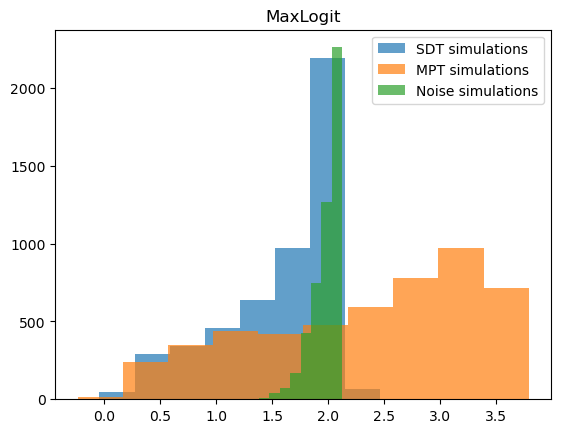

In [16]:
plt.hist(sdt_max_logits, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_logits, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_logits, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxLogit')

# Inspect predictions 

## SDT MPT data

ECE = 0.012


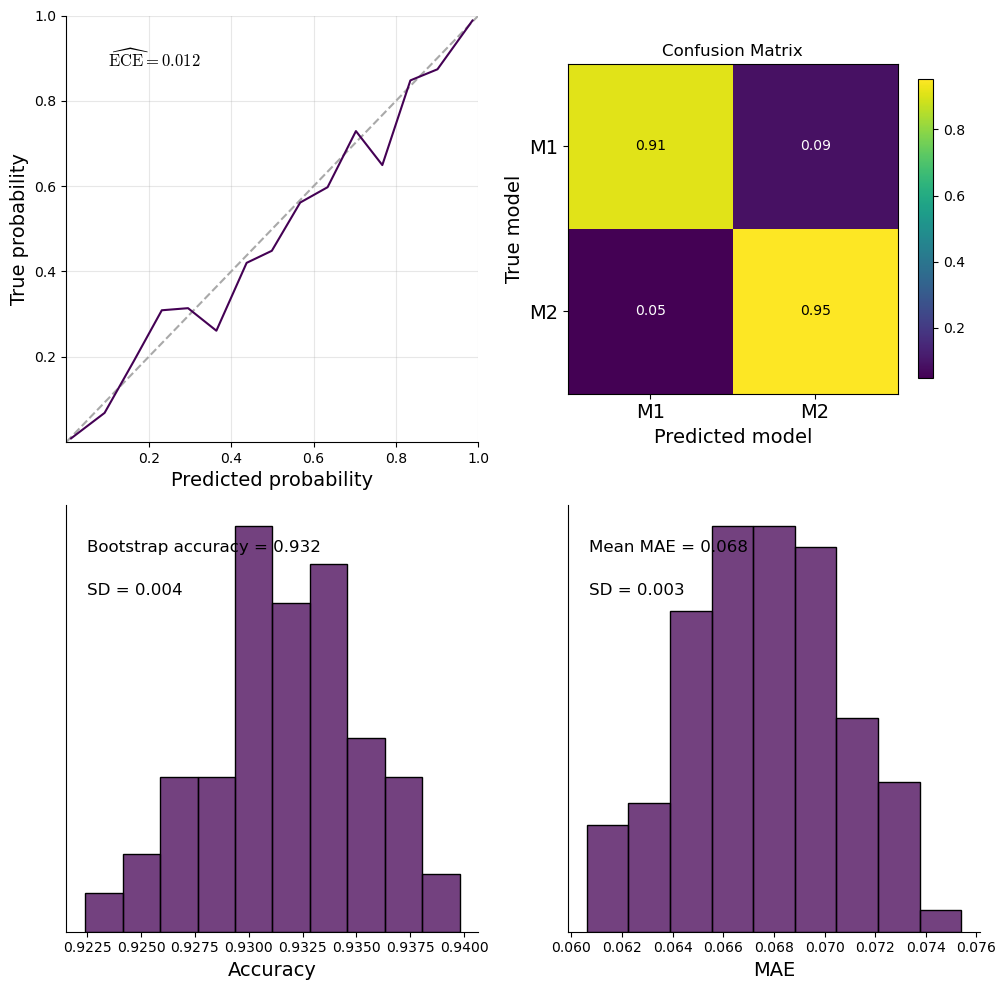

In [17]:
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

## Noisy data

ECE = 0.476


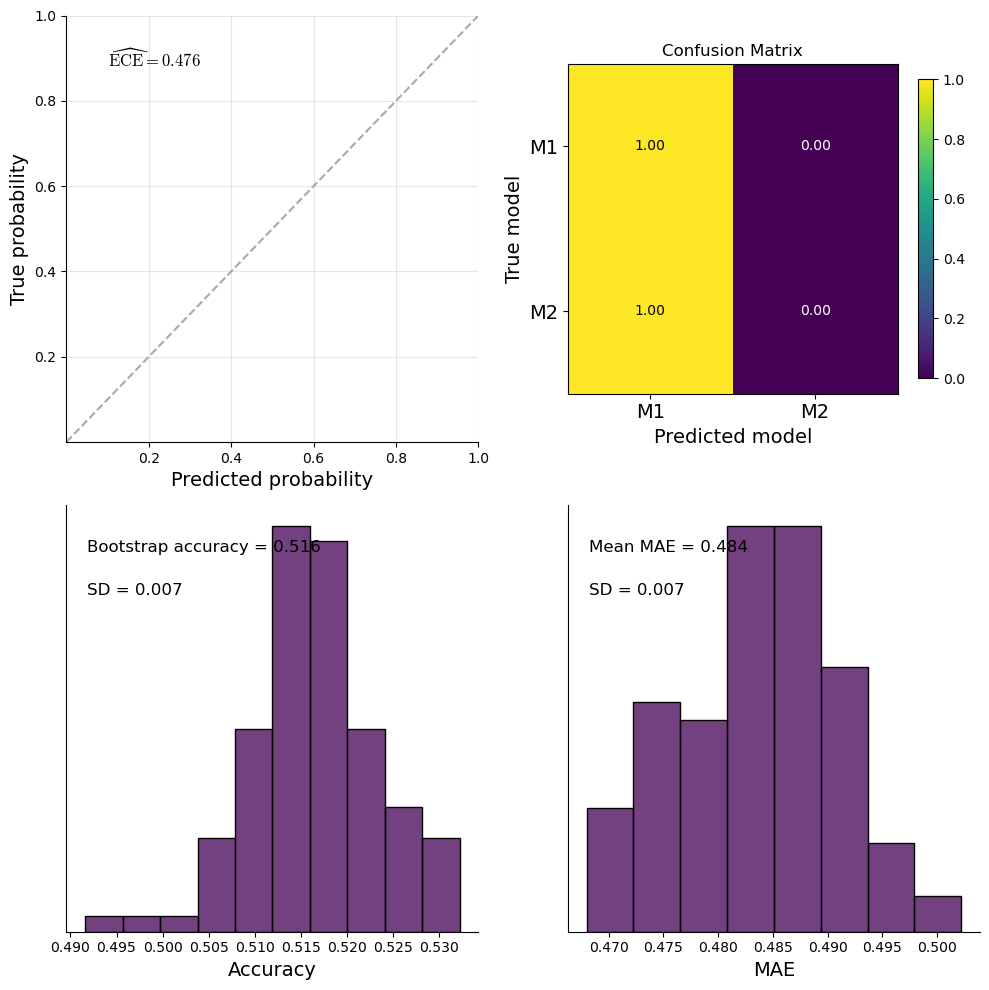

In [18]:
meta_noise = bf.simulation.MultiGenerativeModel([noise_simulator,noise_simulator])
val_data = trainer.configurator(meta_noise(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

In [19]:
# check that both columns of simulated noise data are random
np.mean(noise_data, axis=(0,1,2))

array([0.50016368, 0.49992784])

In [20]:
# inspect predictions
noise_softmax = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_softmax, axis=0)

array([0.99272937, 0.00727116], dtype=float32)

In [21]:
noise_softmax[:10,:]

array([[0.9885203 , 0.01147967],
       [0.9949285 , 0.00507155],
       [0.9953343 , 0.00466567],
       [0.9929119 , 0.00708817],
       [0.995708  , 0.00429199],
       [0.99361646, 0.00638355],
       [0.9947017 , 0.00529826],
       [0.9948673 , 0.00513263],
       [0.9939208 , 0.00607917],
       [0.990049  , 0.00995098]], dtype=float32)

In [22]:
# inspect logits
noise_logits=np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_logits, axis=0)

array([ 1.9819725, -3.0216842], dtype=float32)

In [23]:
noise_logits[:10,:]

array([[ 1.813979 , -2.6416523],
       [ 2.075538 , -3.2034874],
       [ 2.082624 , -3.2802231],
       [ 1.9680597, -2.9741547],
       [ 2.1151547, -3.3315485],
       [ 2.0121014, -3.0355248],
       [ 2.0633361, -3.1717281],
       [ 2.0593562, -3.2076356],
       [ 2.020587 , -3.0762022],
       [ 1.8641787, -2.735905 ]], dtype=float32)

# Generate and save test data for comparison with bridge sampling

In [38]:
n_data_sets = 100
n_clusters = 25
n_obs = 50

noise_data_ood = noise_simulator(n_data_sets, RNG=np.random.default_rng(2023))['sim_data']

In [25]:
# save data sets
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

#np.save(os.path.join(val_folder, 'noise_data_ood'), noise_data_ood)

# Compare predictions

In [26]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2023_06_16_BF_BS_ood'
bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN = probability_net.posterior_probs(summary_net(noise_data_ood))

results_list = [bridge, NN]

In [27]:
NN_array = np.array(NN[:, 0])

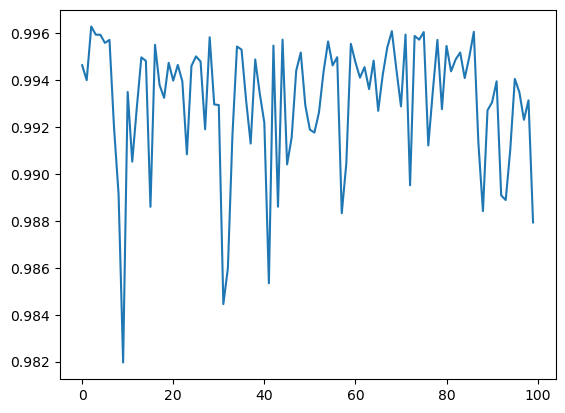

In [28]:
plt.plot(NN_array)

In [29]:
bridge_array = np.array(bridge.loc[:, "m0_prob"])

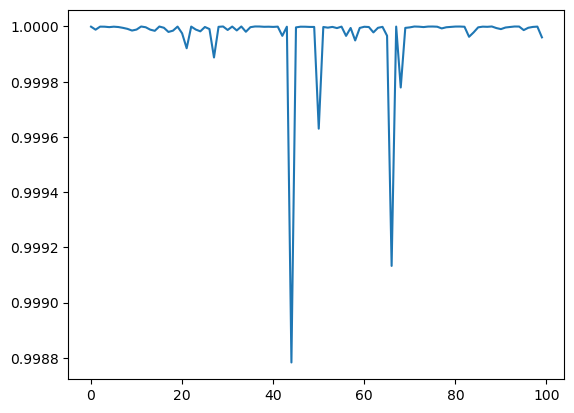

In [30]:
plt.plot(bridge_array)

In [31]:
NN_array

array([0.99463516, 0.99399877, 0.9962871 , 0.9959372 , 0.995934  ,
       0.9955859 , 0.9957145 , 0.99198127, 0.98913634, 0.9819641 ,
       0.9934956 , 0.9905246 , 0.99281996, 0.9949715 , 0.9948185 ,
       0.9885993 , 0.9955057 , 0.99378914, 0.99324507, 0.9947383 ,
       0.9939792 , 0.9946479 , 0.99394727, 0.99083745, 0.9946056 ,
       0.9950111 , 0.9947948 , 0.99190557, 0.9958276 , 0.9929644 ,
       0.99293786, 0.98445266, 0.98598427, 0.99166405, 0.9954332 ,
       0.99530065, 0.9931386 , 0.99129593, 0.9948815 , 0.99342465,
       0.99218905, 0.9853395 , 0.99547136, 0.98860395, 0.9957254 ,
       0.99040914, 0.99155277, 0.9944037 , 0.9951741 , 0.9929241 ,
       0.9918888 , 0.99176395, 0.9926288 , 0.99435437, 0.99564785,
       0.99462754, 0.9949774 , 0.9883266 , 0.9904484 , 0.99554646,
       0.9947647 , 0.9941062 , 0.9945543 , 0.99361455, 0.9948318 ,
       0.9926925 , 0.99422836, 0.99539465, 0.9960873 , 0.9944465 ,
       0.9928819 , 0.9959417 , 0.9895176 , 0.99588495, 0.99572

In [32]:
bridge_array

array([0.99999928, 0.99998839, 0.99999942, 0.99999916, 0.99999763,
       0.99999922, 0.99999799, 0.99999505, 0.99999132, 0.99998525,
       0.99998884, 0.99999986, 0.9999972 , 0.99998851, 0.99998425,
       0.99999984, 0.99999533, 0.99998019, 0.99998487, 0.99999958,
       0.99997513, 0.99992107, 0.9999996 , 0.99998884, 0.99998238,
       0.99999814, 0.99999077, 0.9998877 , 0.99999873, 0.99999994,
       0.99998734, 0.99999968, 0.9999857 , 0.99999996, 0.99998087,
       0.99999746, 0.99999998, 0.99999987, 0.99999882, 0.99999913,
       0.99999844, 0.9999994 , 0.99996606, 0.99999921, 0.99878274,
       0.99999671, 0.99999918, 0.99999907, 0.99999835, 0.99999827,
       0.99962972, 0.99999807, 0.99999576, 0.99999839, 0.99999416,
       0.99999944, 0.99996591, 0.99999459, 0.99994941, 0.99999468,
       0.99999895, 0.999998  , 0.99997853, 0.99999513, 0.99999862,
       0.99996638, 0.99913258, 0.99999963, 0.99977892, 0.99999487,
       0.99999675, 0.99999985, 0.99999922, 0.99999781, 0.99999

In [33]:
print(np.min(NN_array))
print(np.mean(NN_array))
print(np.std(NN_array))

0.9819641
0.99311084
0.002759563


In [34]:
print(np.min(bridge_array))
print(np.mean(bridge_array))
print(np.std(bridge_array))

0.998782742917769
0.9999649589753902
0.00015264912284465896


In [35]:
print(np.mean(NN_array-bridge_array))
print(np.std(NN_array-bridge_array))

-0.006854115674570994
0.002778877007846958


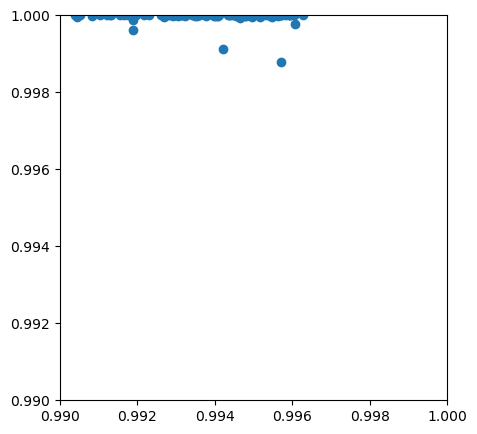

In [36]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_xlim([0.99, 1])
ax.set_ylim([0.99, 1])
ax.scatter(NN_array, bridge_array)